In [1]:
import pyNN.spiNNaker as p
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
from mpl_toolkits.axes_grid1 import ImageGrid
import pyNN.utility.plotting as plot
import numpy as np
import seaborn as sns
import os
import sys
import random
%matplotlib inline

# Printing max length of array that can be created
print(sys.maxsize)

# Importing functions for NMNIST Data
import eventvision as ev

# Setting up simulation
p.setup(timestep=1,time_scale_factor=10)
# p.set_number_of_neurons_per_core(neuron_type=p.IF_cond_exp(),max_permitted=150)

2022-08-10 19:01:29 INFO: Read cfg files: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/bbpnrsoa/.spynnaker.cfg
2022-08-10 19:01:29 INFO: Will search these locations for binaries: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/common_model_binaries : /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/model_binaries
2022-08-10 19:01:29 WARNING: /home/bbpnrsoa/reports has 8 old reports that have not been closed
2022-08-10 19:01:29 INFO: Setting time scale factor to 10.
2022-08-10 19:01:29 INFO: Setting machine time step to 1000 micro-seconds.


9223372036854775807
Event-based vision module imported
['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']


0

In [2]:
# Important Variables
n_excitatory_neurons = 100
excitatory_neuron_parameters = {
    'v_rest':   -65.0,  # Resting membrane potential in mV.
    'cm':         1.0,  # Capacity of the membrane in nF
    'tau_m':     100.0,  # Membrane time constant in ms.
    'tau_refrac': 5.0,  # Duration of refractory period in ms.
    'tau_syn_E':  1.0,  # Decay time of the excitatory synaptic conductance in ms.
    'tau_syn_I':  2.0,  # Decay time of the inhibitory synaptic conductance in ms.
    'e_rev_E':    0.0,  # Reversal potential for excitatory input in mV
    'e_rev_I':  -100.0,  # Reversal potential for inhibitory input in mV
    'v_thresh': -52.0,  # Spike threshold in mV.
    'v_reset':  -65.0,  # Reset potential after a spike in mV.
    'i_offset':   0.0,  # Offset current in nA
}
n_inhibitory_neurons = n_excitatory_neurons
inhibitory_neuron_parameters = {
    'v_rest':   -60.0,  # Resting membrane potential in mV.
    'cm':         1.0,  # Capacity of the membrane in nF
    'tau_m':     10.0,  # Membrane time constant in ms.
    'tau_refrac': 2.0,  # Duration of refractory period in ms.
    'tau_syn_E':  1.0,  # Decay time of the excitatory synaptic conductance in ms.
    'tau_syn_I':  2.0,  # Decay time of the inhibitory synaptic conductance in ms.
    'e_rev_E':    0.0,  # Reversal potential for excitatory input in mV
    'e_rev_I':  -85.0,  # Reversal potential for inhibitory input in mV
    'v_thresh': -40.0,  # Spike threshold in mV.
    'v_reset':  -45.0,  # Reset potential after a spike in mV.
    'i_offset':   0.0,  # Offset current in nA
}

In [3]:
training_data_lists = [os.listdir(os.getcwd()+"/test/"+str(i)+"/") for i in range(10)]
training_class_lens = [len(i) for i in training_data_lists]
num_classes = 10 # Number of Classes
# classes = [i for i in range(num_classes)]
classes = list(range(10)) # i.e. digits 5,6,9
time_per_exp = 750 # Time in ms per example
num_examples_seen = {c:0 for c in classes}
batch_size = 5
# Simulation for batch_size*10 examples will be done together
total_examples = sum(training_class_lens)
class_history = []

In [4]:
print(training_class_lens)

[981, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]


Class is 6
305918


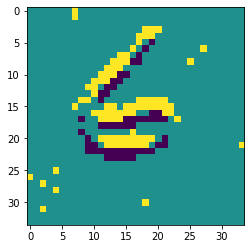

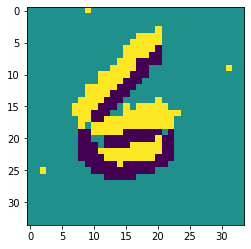

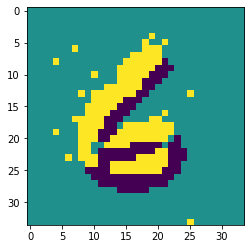

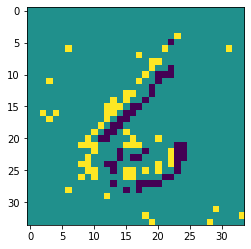

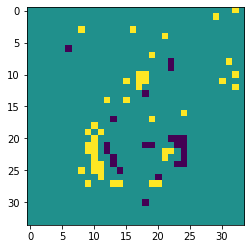

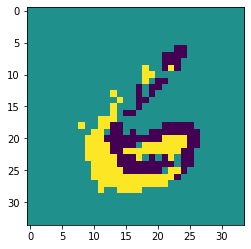

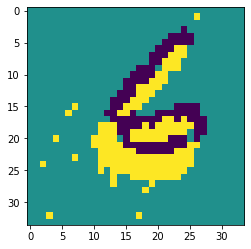

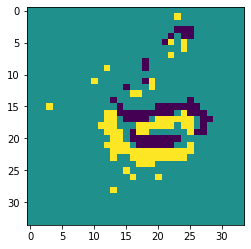

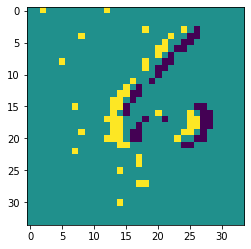

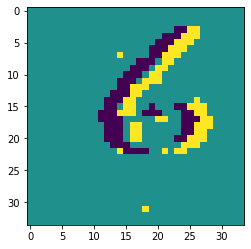

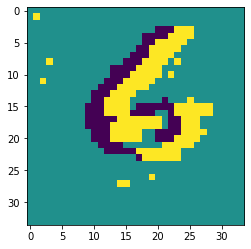

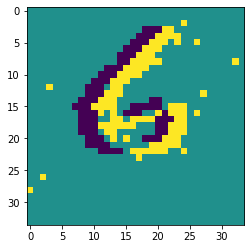

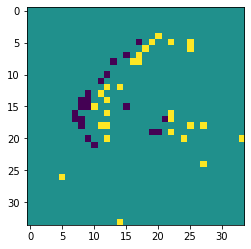

In [5]:
# Displaying a random example
classs = np.random.randint(low=0,high=num_classes)
classs = classes[classs]
num_exp = np.random.randint(low=0,high=training_class_lens[classs])
print("Class is "+str(classs))
disp_exp = ev.read_dataset(os.getcwd()+"/test/"+str(classs)+"/"+str(training_data_lists[classs][num_exp]))
print(disp_exp.data.ts[-1])
disp_exp.show_td(frame_length=24e3)

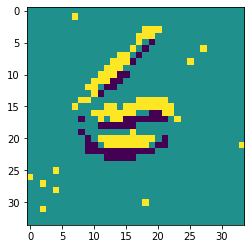

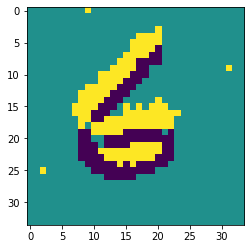

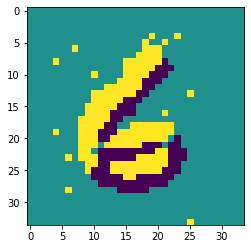

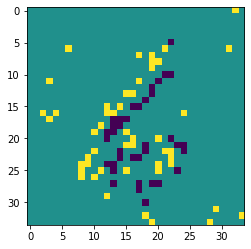

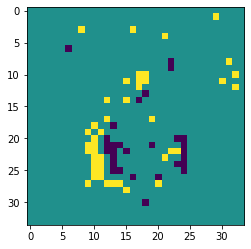

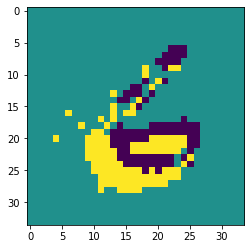

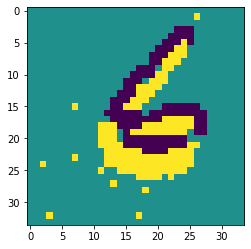

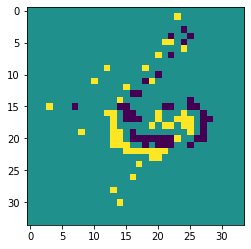

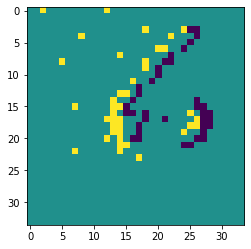

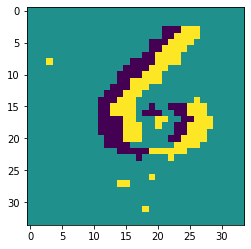

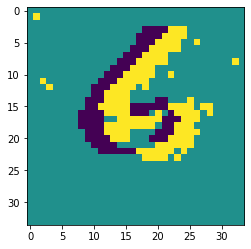

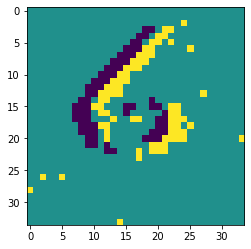

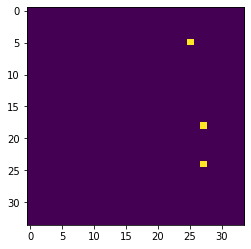

In [6]:
#Scaled down data
for i in range(len(disp_exp.data.ts)):
    disp_exp.data.ts[i]=disp_exp.data.ts[i]//1000
disp_exp.show_td(frame_length=24)

In [7]:
# Maximum spike time is 315474 micro seconds (number 6)
# Random Class selector
# class_selector = np.random.randint(low=0,high=num_classes,size=batch_size*num_classes)
class_selector = []
for i in range(batch_size):
    random.shuffle(classes)
    class_selector+=classes
class_history+=list(class_selector)
spike_array = [[] for _ in range(34*34)]
for classs in class_selector:
    data_point = ev.read_dataset(os.getcwd()+"/test/"+str(classs)+"/"+str(training_data_lists[classs][num_examples_seen[classs]]))
    data_point_spike_array = [[] for _ in range(34*34)]
    for d in range(len(data_point.data.x)):
        if data_point.data.p[d]: # Polarity = ON
            data_point_spike_array[data_point.data.x[d]*34+data_point.data.y[d]].append(data_point.data.ts[d]//1000+time_per_exp*sum(num_examples_seen.values())+50)# Plus 50 as first 50 mseconds is just to simulate start spike
    num_examples_seen[classs]+=1
    idx_sa = 0
    for sa,dpsa in zip(spike_array,data_point_spike_array):
        spike_array[idx_sa] = sa+dpsa
        idx_sa+=1
num_events=0
for i in spike_array:
    num_events+=len(i)
print("Number of events is "+str(num_events))

Number of events is 104341


In [8]:
# input
inp = p.Population(1156,
                   p.SpikeSourceArray(spike_array),
                   label="Input"
                  )
# excitatory
exc = p.Population(n_excitatory_neurons,
                   p.IF_cond_exp(**excitatory_neuron_parameters),
                   initial_values={'v': excitatory_neuron_parameters["v_rest"]},
                   label="Excitatory"
                  )
# inhibitory
inh = p.Population(n_inhibitory_neurons,
                   p.IF_cond_exp(**inhibitory_neuron_parameters),
                   initial_values={'v': inhibitory_neuron_parameters["v_rest"]},
                   label="Inhibitory"
                  )

In [9]:
# Record Spikes
inp.record("spikes") # Testing
exc.record(["spikes",'gsyn_exc', 'gsyn_inh','v'])
inh.record(["spikes",'gsyn_exc', 'gsyn_inh','v'])

In [10]:
min_weight = 0
max_weight = 1
# E -> I
# e_i_weight_rand = p.RandomDistribution(distribution='uniform',low=0.0,high=max_weight)
p.Projection(presynaptic_population = exc,
             postsynaptic_population = inh,
             connector = p.OneToOneConnector(),
             synapse_type = p.StaticSynapse(weight=1,delay=1.0),
             receptor_type = 'excitatory'
            )

# I -> E
i_e_connection_list = []
for i in range(n_excitatory_neurons):
    for j in range(n_inhibitory_neurons):
        if not i==j:
            i_e_connection_list.append((i,j))
p.Projection(presynaptic_population = inh,
             postsynaptic_population = exc,
             connector = p.FromListConnector(i_e_connection_list),
             synapse_type = p.StaticSynapse(weight=0.0625,delay=1.0), # 0.0001
             receptor_type = 'inhibitory'
            )

# Input -> E
stdp_initial_weights = p.RandomDistribution(distribution='normal_clipped',low=0,high=1, mu=0.5, sigma=0.3)
print("Testing stdp initial weight random generator, rand value = ",str(stdp_initial_weights.next()))
timing_rule = p.SpikePairRule(tau_plus=8.0,tau_minus=2.0, #8,1
                             A_plus=0.0625,A_minus=0.0625) # 80,20
weight_rule = p.AdditiveWeightDependence(w_max=max_weight,w_min=min_weight)
# weight_rule = p.MultiplicativeWeightDependence(w_min=min_weight, w_max=max_weight)
stdp_model = p.STDPMechanism(timing_dependence=timing_rule,
                            weight_dependence=weight_rule,
                            weight=stdp_initial_weights,delay=1.0)
stdp_proj = p.Projection(presynaptic_population = inp,
             postsynaptic_population = exc,
             connector = p.AllToAllConnector(),
             synapse_type = stdp_model,
             receptor_type = 'excitatory'
            )

Testing stdp initial weight random generator, rand value =  0.8639368226228585


In [11]:
# Printing initial weights
p.run(50)
initial_weights = stdp_proj.get(["weight"],"list", with_address=False)

2022-08-10 19:01:37 INFO: Starting execution process
2022-08-10 19:01:37 INFO: Simulating for 50 1.0ms timesteps using a hardware timestep of 10000us
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2022-08-10 19:01:37 INFO: Time 0:00:00.008833 taken by SpynnakerSplitterSelector
Adding delay extensions as required
|0%                          50%                         100%|
2022-08-10 19:01:37 INFO: Time 0:00:00.008690 taken by DelaySupportAdder
2022-08-10 19:01:40 INFO: Time 0:00:03.149930 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2022-08-10 19:01:49 INFO: Time 0:00:08.351096 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2022-08-1

In [12]:
# Simulating
p.run(batch_size*num_classes*time_per_exp)

2022-08-10 19:02:43 INFO: Starting execution process
2022-08-10 19:02:43 INFO: Simulating for 37500 1.0ms timesteps using a hardware timestep of 10000us
2022-08-10 19:02:43 INFO: Running for 1 steps for a total of 37500.0ms
2022-08-10 19:02:43 INFO: Run 1 of 1
Generating SDRAM usage report
|0%                          50%                         100%|
2022-08-10 19:02:43 INFO: Time 0:00:00.072037 taken by SdramUsageReportPerChip
2022-08-10 19:02:43 INFO: ** Notifying external sources that the database is ready for reading **
2022-08-10 19:02:43 INFO: Time 0:00:00.001240 taken by CreateNotificationProtocol
Getting provenance data from machine graph
|0%                          50%                         100%|
Getting provenance data from application graph
|0%                          50%                         100%|
2022-08-10 19:02:43 INFO: Time 0:00:00.088470 taken by GraphProvenanceGatherer
Reloading data
|0%                          50%                         100%|
2022-08-10 19:

37550.0

In [13]:
# Getting Weights and spikes
weights = stdp_proj.get(["weight"],"list", with_address=False)
weights_address = stdp_proj.get(["weight"],"list")
# print(weights)
inp_spikes = inp.get_data("spikes")
# print(inp_spikes.segments[0].spiketrains)
exc_spikes = exc.get_data("spikes")
# print(exc_spikes.segments[0].spiketrains)
inh_spikes = inh.get_data("spikes")
# print(inh_spikes.segments[0].spiketrains)

Getting synaptic data between Input and Excitatory
|0%                          50%                         100%|
Getting synaptic data between Input and Excitatory
|0%                          50%                         100%|
Getting spikes for Input
|0%                          50%                         100%|
Getting spikes for Excitatory
|0%                          50%                         100%|
Getting spikes for Inhibitory
|0%                          50%                         100%|


In [14]:
exc_v = exc.get_data("v")
exc_ge = exc.get_data('gsyn_exc')
exc_gi = exc.get_data('gsyn_inh')
inh_v = inh.get_data("v")
inh_ge = inh.get_data('gsyn_exc')
inh_gi = inh.get_data('gsyn_inh')

Getting v for Excitatory
|0%                          50%                         100%|
Getting gsyn_exc for Excitatory
|0%                          50%                         100%|
Getting gsyn_inh for Excitatory
|0%                          50%                         100%|
Getting v for Inhibitory
|0%                          50%                         100%|
Getting gsyn_exc for Inhibitory
|0%                          50%                         100%|
Getting gsyn_inh for Inhibitory
|0%                          50%                         100%|


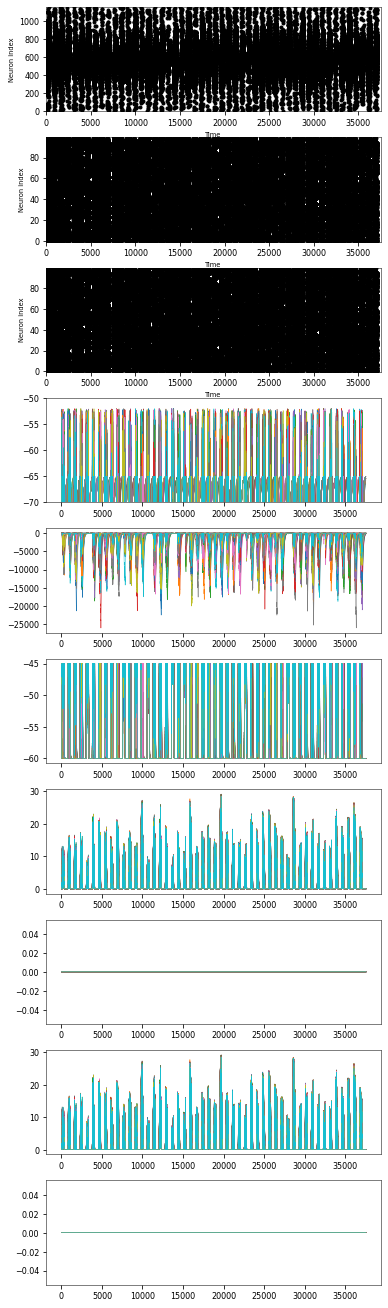

In [15]:
# Plotting spikes
plot.Figure(
    plot.Panel(inp_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time"),
    plot.Panel(exc_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time"),
    plot.Panel(inh_spikes.segments[0].spiketrains,yticks=True,xticks=True,xlabel="Time"),
    plot.Panel(exc_v.segments[0].filter(name='v')[0],yticks=True,xticks=True,legend=None,ylim=(-70,-50)),
    plot.Panel(exc_v.segments[0].filter(name='v')[0],yticks=True,xticks=True,legend=None),
    plot.Panel(inh_v.segments[0].filter(name='v')[0],yticks=True,xticks=True,legend=None),
    plot.Panel(exc_ge.segments[0].filter(name='gsyn_exc')[0],yticks=True,xticks=True,legend=None),
    plot.Panel(inh_gi.segments[0].filter(name='gsyn_inh')[0],yticks=True,xticks=True,legend=None),
    plot.Panel(exc_ge.segments[0].filter(name='gsyn_exc')[0],yticks=True,xticks=True,legend=None),
    plot.Panel(inh_gi.segments[0].filter(name='gsyn_inh')[0],yticks=True,xticks=True,legend=None)
)

In [16]:
spikes = exc_spikes.segments[0].spiketrains
# print(len(list(spikes)))
spike_counts = [{i:0 for i in classes} for i in range(n_excitatory_neurons)]
# print(spike_counts)
for i in range(n_excitatory_neurons):
#     print(i)
    for j in list(spikes[i]):
#         print(0,i,int(j)%500)
#         print(1,i,class_history[int(j)//750])
        spike_counts[i][class_history[int(j)//time_per_exp]]+=1
labels = [0]*100
for i in range(len(spike_counts)):
    labels[i] = max(spike_counts[i], key=spike_counts[i].get)
print("Number of examples seen")
print(num_examples_seen)
print("Labels")
print(labels)
num_labels = {i:0 for i in classes}
for i in labels:
    num_labels[i]+=1
print("Number of labels")
print(num_labels)

Number of examples seen
{0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5}
Labels
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of labels
{6: 0, 9: 0, 7: 0, 1: 99, 4: 0, 0: 0, 8: 0, 3: 0, 5: 0, 2: 1}
